In [1]:
%matplotlib inline

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.stats as stats

from IPython.display import display
from ipywidgets import *

from pyearth import Earth
from sklearn import cross_validation

### Utilities

In [2]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    

### Importing data

In [3]:
# finn's data set 
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 115


In [ ]:
# extended data set
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
data2 = sio.loadmat('rfMRI_REST1_HCP_S500.mat')
gF2 = np.ravel(data2['PMAT24_A_CR'])
data_ext = np.concatenate((data['rest_1_mat'],data2['rest_1_mat']),axis=2)
gF = np.concatenate((gF,gF2))
n_subj = len(gF)
print('No. of subjects:',n_subj)

In [ ]:
# improved preprocessing
data = sio.loadmat('improved_preproc/rfMRI_REST1_HCP_Q2.mat')
#data = sio.loadmat('improved_preproc/rfMRI_REST2_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

### gF score distribution

In [ ]:
# gF score distribution 
def plot_hist(n_bins):
    plt.hist(gF, bins=n_bins)
    plt.title("gF score distribution")
    plt.xlabel("gF")
    plt.ylabel("Frequency")
    plt.show()
    return n_bins
    
interact(plot_hist, n_bins=(5,50,5)) 

In [ ]:
# needed for stratified k-fold
n_bins = 4
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:,-1])
print(bin_limits)

### Building input matrix

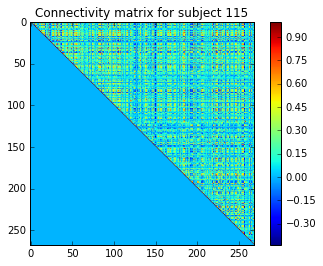

In [4]:
# choose dataset
conn_mats = data['rest_1_mat']
#conn_mats = data['rest_1_mat']
#conn_mats = data_ext

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]

### Test
The generalization ability of the model is assessed with an outer leave-one-out cross validation loop.

In [ ]:
k=5
n_bins_cv = 4
loo = cross_validation.LeaveOneOut(n_subj)
errors = np.zeros([n_subj,1])
predictions = np.zeros([n_subj,1])
i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    X_train, X_test, y_train, y_test = edges[train_index,], edges[test_index,],gF[train_index],gF[test_index]
    hist_cv, bin_limits_cv = np.histogram(y_train, n_bins_cv)
    bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
    cv = cross_validation.StratifiedKFold(bins_cv,k)
    model = Earth()
    model.fit(X_train,y_train)
    predictions[i] = model.predict(X_test)
    errors[i] = abs(predictions[i]-gF[test_index])
    i+=1
    f.value += 1
print(np.mean(errors))
preds_1 = predictions



In [ ]:
results = {'mars':preds_1, 'score':gF}
sio.savemat('res_mars_loo.mat', results)

In [ ]:
results = sio.loadmat('mars_loo.mat')
results['mars_improved_1'] = preds_2
sio.savemat('res_mars_loo.mat',results)

In [ ]:
results = sio.loadmat('mars_loo.mat')
results['mars_improved_2'] = preds_3
sio.savemat('res_mars_loo.mat',results)

In [ ]:
regression_plot(np.ravel(gF),np.ravel(preds_1),n_subj,'MARS on Finn\'s data - all edges') 

In [ ]:
regression_plot(np.ravel(gF),np.ravel(preds_2),n_subj,'MARS on Rest1 (improved preprocessing)') 

In [ ]:
regression_plot(np.ravel(gF),np.ravel(preds_3),n_subj,'MARS on Rest2 (improved preprocessing)') 